In [7]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Model Libraries
from sklearn.ensemble import RandomForestClassifier

In [8]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [9]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [10]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [11]:
df.shape

(292, 15)

In [12]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [13]:
X = df.iloc[:, 2:9]

## Train/Test Split

In [14]:
X.head(1)

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [15]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [16]:
for col in X:
    X[col] = X[col].astype(int)

In [17]:
X['broken_link_score']

0      1
1      0
2      1
3      1
4      1
      ..
435    0
436    1
437    0
438    0
440    0
Name: broken_link_score, Length: 292, dtype: int64

In [18]:
X.shape

(292, 7)

In [19]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
model_choice = RandomForestClassifier()

In [22]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [23]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [24]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [25]:
y_pred_proba = clf.predict_proba(X_test)

In [26]:
np.round(accuracy_score(y_test, y_pred), 2)

0.85

In [27]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [28]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [29]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.826, 0.149)

In [30]:
tn, fp, fn, tp

(63, 11, 4, 19)

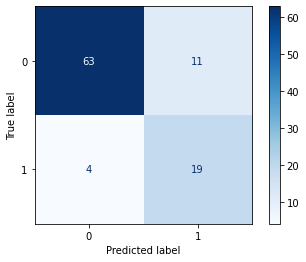

In [31]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [33]:
auc_score = auc(fpr, tpr)

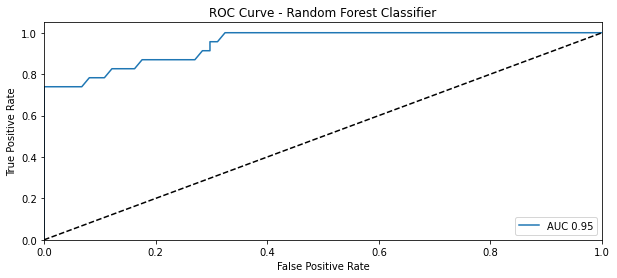

In [35]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='AUC %0.2f' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")

# # find optimum thresholds
# i = np.arange(len(tpr)) # index for df
# roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
# df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# # create the axis of thresholds (scores)
# ax2 = plt.gca().twinx()
# ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
# ax2.set_ylabel('Threshold',color='darkred')
# ax2.set_ylim([thresholds[-1],thresholds[0]])
# ax2.set_xlim([fpr[0],fpr[-1]])
# ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
# print(" -- Optimum Threshold -- ")
# print(df_thresh)

In [36]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 2.0
TPR 0.7391304347826086, FPR 0.0, Threshold 1.0
TPR 0.7391304347826086, FPR 0.013513513513513514, Threshold 0.7660833333333333
TPR 0.7391304347826086, FPR 0.05405405405405406, Threshold 0.7284999999999999
TPR 0.7391304347826086, FPR 0.06756756756756757, Threshold 0.6643333333333333
TPR 0.782608695652174, FPR 0.08108108108108109, Threshold 0.66
TPR 0.782608695652174, FPR 0.10810810810810811, Threshold 0.5358333333333334
TPR 0.8260869565217391, FPR 0.12162162162162163, Threshold 0.5356428571428572
TPR 0.8260869565217391, FPR 0.14864864864864866, Threshold 0.5255833333333333
TPR 0.8260869565217391, FPR 0.16216216216216217, Threshold 0.4726190476190476
TPR 0.8695652173913043, FPR 0.17567567567567569, Threshold 0.4203112165612166
TPR 0.8695652173913043, FPR 0.1891891891891892, Threshold 0.41906593406593406
TPR 0.8695652173913043, FPR 0.21621621621621623, Threshold 0.395
TPR 0.8695652173913043, FPR 0.2702702702702703, Threshold 0.17657

## Bootstrapped

In [37]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.9633333333333334, Accuracy:0.8762886597938144
Iteration 1: AUC:0.9026369168356998, Accuracy:0.7835051546391752
Iteration 2: AUC:0.9339012925969449, Accuracy:0.845360824742268
Iteration 3: AUC:0.9320776255707762, Accuracy:0.9278350515463918
Iteration 4: AUC:0.8526543878656555, Accuracy:0.865979381443299
Iteration 5: AUC:0.9214285714285714, Accuracy:0.8556701030927835
Iteration 6: AUC:0.9355769230769231, Accuracy:0.8556701030927835
Iteration 7: AUC:0.9091666666666667, Accuracy:0.8556701030927835
Iteration 8: AUC:0.8553082191780822, Accuracy:0.8041237113402062
Iteration 9: AUC:0.9453584018801411, Accuracy:0.8762886597938144
Iteration 10: AUC:0.9598861283643892, Accuracy:0.8762886597938144
Iteration 11: AUC:0.8924949290060852, Accuracy:0.8247422680412371
Iteration 12: AUC:0.9264550264550264, Accuracy:0.9072164948453608
Iteration 13: AUC:0.8955026455026456, Accuracy:0.8556701030927835
Iteration 14: AUC:0.9240867579908676, Accuracy:0.8762886597938144
Iteration 15: AUC:0.81

Iteration 126: AUC:0.9375661375661375, Accuracy:0.8556701030927835
Iteration 127: AUC:0.86, Accuracy:0.8350515463917526
Iteration 128: AUC:0.873090481786134, Accuracy:0.8144329896907216
Iteration 129: AUC:0.9192126909518213, Accuracy:0.8556701030927835
Iteration 130: AUC:0.8998237367802584, Accuracy:0.8350515463917526
Iteration 131: AUC:0.8987854251012145, Accuracy:0.865979381443299
Iteration 132: AUC:0.9509090909090909, Accuracy:0.8865979381443299
Iteration 133: AUC:0.9021739130434783, Accuracy:0.845360824742268
Iteration 134: AUC:0.9072008113590264, Accuracy:0.865979381443299
Iteration 135: AUC:0.8735449735449736, Accuracy:0.8247422680412371
Iteration 136: AUC:0.8473173515981735, Accuracy:0.8350515463917526
Iteration 137: AUC:0.9585781433607521, Accuracy:0.8350515463917526
Iteration 138: AUC:0.9091666666666667, Accuracy:0.8556701030927835
Iteration 139: AUC:0.9396825396825397, Accuracy:0.865979381443299
Iteration 140: AUC:0.9439393939393939, Accuracy:0.8556701030927835
Iteration 141:

Iteration 250: AUC:0.9216911764705882, Accuracy:0.8556701030927835
Iteration 251: AUC:0.9515276145710929, Accuracy:0.9175257731958762
Iteration 252: AUC:0.8940298507462686, Accuracy:0.865979381443299
Iteration 253: AUC:0.947883597883598, Accuracy:0.865979381443299
Iteration 254: AUC:0.9373134328358209, Accuracy:0.8556701030927835
Iteration 255: AUC:0.9065804935370153, Accuracy:0.8556701030927835
Iteration 256: AUC:0.9477085781433607, Accuracy:0.8762886597938144
Iteration 257: AUC:0.9170892494929006, Accuracy:0.8556701030927835
Iteration 258: AUC:0.9301697530864198, Accuracy:0.8556701030927835
Iteration 259: AUC:0.8638698630136985, Accuracy:0.865979381443299
Iteration 260: AUC:0.9418831168831169, Accuracy:0.8762886597938144
Iteration 261: AUC:0.9185185185185185, Accuracy:0.8762886597938144
Iteration 262: AUC:0.843454790823212, Accuracy:0.8247422680412371
Iteration 263: AUC:0.9769269776876267, Accuracy:0.8865979381443299
Iteration 264: AUC:0.9121693121693121, Accuracy:0.865979381443299
I

Iteration 374: AUC:0.9078690127077224, Accuracy:0.845360824742268
Iteration 375: AUC:0.9103641456582634, Accuracy:0.865979381443299
Iteration 376: AUC:0.9083333333333334, Accuracy:0.8247422680412371
Iteration 377: AUC:0.8566137566137566, Accuracy:0.845360824742268
Iteration 378: AUC:0.869090909090909, Accuracy:0.8247422680412371
Iteration 379: AUC:0.9157575757575757, Accuracy:0.9072164948453608
Iteration 380: AUC:0.9102746212121212, Accuracy:0.8144329896907216
Iteration 381: AUC:0.8996753246753246, Accuracy:0.865979381443299
Iteration 382: AUC:0.8833725029377203, Accuracy:0.8144329896907216
Iteration 383: AUC:0.9105820105820106, Accuracy:0.8041237113402062
Iteration 384: AUC:0.9265010351966874, Accuracy:0.8762886597938144
Iteration 385: AUC:0.888095238095238, Accuracy:0.8350515463917526
Iteration 386: AUC:0.8912698412698413, Accuracy:0.865979381443299
Iteration 387: AUC:0.9386415525114156, Accuracy:0.8762886597938144
Iteration 388: AUC:0.9308333333333334, Accuracy:0.8762886597938144
It

Iteration 498: AUC:0.9127843986998917, Accuracy:0.8762886597938144
Iteration 499: AUC:0.8683640303358613, Accuracy:0.8247422680412371
Iteration 500: AUC:0.9256493506493506, Accuracy:0.8556701030927835
Iteration 501: AUC:0.9105820105820106, Accuracy:0.845360824742268
Iteration 502: AUC:0.9188888888888889, Accuracy:0.8350515463917526
Iteration 503: AUC:0.8377329192546583, Accuracy:0.8041237113402062
Iteration 504: AUC:0.9336075205640424, Accuracy:0.9175257731958762
Iteration 505: AUC:0.8804232804232804, Accuracy:0.8350515463917526
Iteration 506: AUC:0.9251322751322751, Accuracy:0.845360824742268
Iteration 507: AUC:0.896551724137931, Accuracy:0.8350515463917526
Iteration 508: AUC:0.9482961222091657, Accuracy:0.8762886597938144
Iteration 509: AUC:0.882453567937439, Accuracy:0.7731958762886598
Iteration 510: AUC:0.9550000000000001, Accuracy:0.8865979381443299
Iteration 511: AUC:0.9165763813651138, Accuracy:0.845360824742268
Iteration 512: AUC:0.9542424242424242, Accuracy:0.9072164948453608


Iteration 622: AUC:0.8467908902691511, Accuracy:0.8144329896907216
Iteration 623: AUC:0.9047619047619047, Accuracy:0.8350515463917526
Iteration 624: AUC:0.9083431257344301, Accuracy:0.8556701030927835
Iteration 625: AUC:0.9030335861321777, Accuracy:0.7938144329896907
Iteration 626: AUC:0.9054621848739496, Accuracy:0.8350515463917526
Iteration 627: AUC:0.8547222222222222, Accuracy:0.845360824742268
Iteration 628: AUC:0.9730555555555556, Accuracy:0.9278350515463918
Iteration 629: AUC:0.8895921237693389, Accuracy:0.845360824742268
Iteration 630: AUC:0.9297945205479452, Accuracy:0.8865979381443299
Iteration 631: AUC:0.9193657219973009, Accuracy:0.8762886597938144
Iteration 632: AUC:0.950352526439483, Accuracy:0.865979381443299
Iteration 633: AUC:0.9393034825870646, Accuracy:0.9072164948453608
Iteration 634: AUC:0.9769772481040088, Accuracy:0.8969072164948454
Iteration 635: AUC:0.9256613756613756, Accuracy:0.845360824742268
Iteration 636: AUC:0.904109589041096, Accuracy:0.8556701030927835
I

Iteration 746: AUC:0.9421906693711968, Accuracy:0.865979381443299
Iteration 747: AUC:0.9338888888888889, Accuracy:0.845360824742268
Iteration 748: AUC:0.8559701492537314, Accuracy:0.8144329896907216
Iteration 749: AUC:0.9068783068783068, Accuracy:0.865979381443299
Iteration 750: AUC:0.9277950310559007, Accuracy:0.865979381443299
Iteration 751: AUC:0.9412698412698413, Accuracy:0.8556701030927835
Iteration 752: AUC:0.933001893939394, Accuracy:0.8556701030927835
Iteration 753: AUC:0.9417659804983748, Accuracy:0.8556701030927835
Iteration 754: AUC:0.9338888888888888, Accuracy:0.845360824742268
Iteration 755: AUC:0.9437785388127855, Accuracy:0.8865979381443299
Iteration 756: AUC:0.8727777777777778, Accuracy:0.8556701030927835
Iteration 757: AUC:0.9333333333333333, Accuracy:0.865979381443299
Iteration 758: AUC:0.9295112781954886, Accuracy:0.8350515463917526
Iteration 759: AUC:0.876909518213866, Accuracy:0.8247422680412371
Iteration 760: AUC:0.9158105022831051, Accuracy:0.845360824742268
Iter

Iteration 870: AUC:0.9182194616977226, Accuracy:0.865979381443299
Iteration 871: AUC:0.9216417910447761, Accuracy:0.865979381443299
Iteration 872: AUC:0.9265010351966874, Accuracy:0.8762886597938144
Iteration 873: AUC:0.9285714285714285, Accuracy:0.8556701030927835
Iteration 874: AUC:0.9103995299647474, Accuracy:0.7938144329896907
Iteration 875: AUC:0.9390909090909092, Accuracy:0.8556701030927835
Iteration 876: AUC:0.876969696969697, Accuracy:0.7938144329896907
Iteration 877: AUC:0.9021164021164021, Accuracy:0.8865979381443299
Iteration 878: AUC:0.9334134615384616, Accuracy:0.8762886597938144
Iteration 879: AUC:0.8849885844748859, Accuracy:0.8247422680412371
Iteration 880: AUC:0.9583333333333333, Accuracy:0.845360824742268
Iteration 881: AUC:0.9076704545454546, Accuracy:0.8350515463917526
Iteration 882: AUC:0.8460410557184751, Accuracy:0.7938144329896907
Iteration 883: AUC:0.9209090909090909, Accuracy:0.8350515463917526
Iteration 884: AUC:0.9460199004975125, Accuracy:0.865979381443299


Iteration 994: AUC:0.946917808219178, Accuracy:0.8865979381443299
Iteration 995: AUC:0.9502777777777778, Accuracy:0.865979381443299
Iteration 996: AUC:0.9456521739130435, Accuracy:0.8556701030927835
Iteration 997: AUC:0.9283088235294118, Accuracy:0.8247422680412371
Iteration 998: AUC:0.8752587991718428, Accuracy:0.845360824742268
Iteration 999: AUC:0.944235588972431, Accuracy:0.8865979381443299


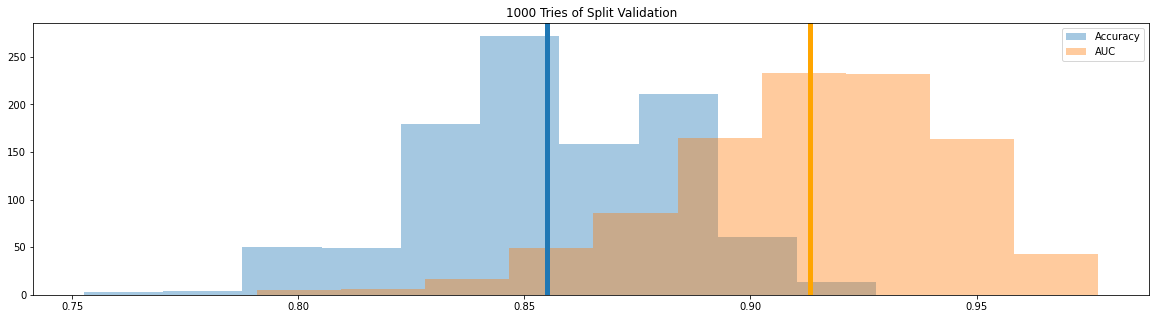

Accuracy mean: 0.85
AUC mean: 0.91


In [38]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Cross Validation & Hyperparameter Tuning

#### Process

In [40]:
params = {"n_estimators": [10, 20, 50, 100, 200, 400, 800, 1000],
          "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
          "bootstrap": [True, False],
          "min_samples_split": [1,3,5,7]}

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_choice = RandomForestClassifier(random_state=0)

In [42]:
kfold = StratifiedKFold(n_splits=5)
cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

In [43]:
cv_results

array([0.92857143, 0.79220779, 0.86038961, 0.95779221, 0.97931034])

In [44]:
## Get the best fold train data to be tested on dataset B
i = 0
idx_train_best = []
idx_test_best = []
for train, test in kfold.split(X_train, y_train):
    if i == np.argmax(cv_results):
        idx_train_best = train
        idx_test_best = test
    i += 1

In [45]:
X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

In [46]:
X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

In [47]:
clf = model_choice.fit(X_train_best, y_train_best.values.ravel())
y_best_proba = clf.predict_proba(X_test_best)
fpr, tpr, thresholds = roc_curve(y_test_best, y_best_proba[:,1])
auc_score = auc(fpr, tpr)
## Check its the same as cv_results
auc_score

0.9793103448275862

In [48]:
## Test the best fold to dataset B
clf = model_choice.fit(X_train_best, y_train_best.values.ravel())
y_test_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
## Check the AUC on dataset B
auc_score

0.940364277320799

#### Calculate Results

In [52]:
## Results
best_fold = []
best_fold_auc = []
dataset_b_auc = []
parameter_1 = []
parameter_2 = []
parameter_3 = []
parameter_4 = []
idx_train_data = []

## Hyperparameters
params = {"n_estimators": [100, 200, 400, 800, 1000],
          "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
          "bootstrap": [True, False],
          "min_samples_split": [2, 3, 5, 7, 10]}

## Split the data to dataset A (train) and dataset B (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Split dataset A (train) to 5 folds
kfold = StratifiedKFold(n_splits=5)

for i in range(len(params['n_estimators'])):
    for j in range(len(params['max_depth'])):
        for k in range(len(params['bootstrap'])):
            for l in range(len(params['min_samples_split'])):
        
                ## Fit the params
                model_choice = RandomForestClassifier\
                (random_state=0, n_estimators=params['n_estimators'][i], max_depth=params['max_depth'][j],\
                 bootstrap=params['bootstrap'][k], min_samples_split=params['min_samples_split'][l])

                ## Do cross validation
                cv_results = cross_val_score(model_choice, X_train, y_train.values.ravel(), cv=kfold, scoring='roc_auc')

                ## Get the index best fold train data to be tested on dataset B
                idx = 0
                idx_train_best = []
                idx_test_best = []
                for train, test in kfold.split(X_train, y_train):
                    if idx == np.argmax(cv_results):
                        idx_train_best = train
                        idx_test_best = test
                    idx += 1

                ## Get the best fold train and test data
                X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
                y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

                X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
                y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

                ## Fit the model with the best fold data
                clf = model_choice.fit(X_train_best, y_train_best.values.ravel())

                ## Test the best fold to dataset B
                ## Check the AUC on dataset B
                y_test_proba = clf.predict_proba(X_test)
                fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
                auc_score = auc(fpr, tpr)

                best_fold.append(np.argmax(cv_results)+1)
                best_fold_auc.append(np.max(cv_results))
                dataset_b_auc.append(auc_score)
                parameter_1.append(params['n_estimators'][i])
                parameter_2.append(params['max_depth'][j])
                parameter_3.append(params['bootstrap'][k])
                parameter_4.append(params['min_samples_split'][l])
                idx_train_data.append(idx_train_best)

                print("N Estimators: %s, Max Depth: %s, Bootstrap: %s, Min. Samples Split: %s, Best Fold AUC: %s (Fold %s), Dataset B AUC: %s" \
                      % (params['n_estimators'][i], params['max_depth'][j], params['bootstrap'][k],\
                         params['min_samples_split'][l], np.max(cv_results), np.argmax(cv_results)+1, auc_score))

N Estimators: 100, Max Depth: 3, Bootstrap: True, Min. Samples Split: 2, Best Fold AUC: 0.961038961038961 (Fold 1), Dataset B AUC: 0.9468272620446534
N Estimators: 100, Max Depth: 3, Bootstrap: True, Min. Samples Split: 3, Best Fold AUC: 0.961038961038961 (Fold 1), Dataset B AUC: 0.9468272620446534
N Estimators: 100, Max Depth: 3, Bootstrap: True, Min. Samples Split: 5, Best Fold AUC: 0.961038961038961 (Fold 1), Dataset B AUC: 0.9474148061104583
N Estimators: 100, Max Depth: 3, Bootstrap: True, Min. Samples Split: 7, Best Fold AUC: 0.961038961038961 (Fold 1), Dataset B AUC: 0.9468272620446534
N Estimators: 100, Max Depth: 3, Bootstrap: True, Min. Samples Split: 10, Best Fold AUC: 0.961038961038961 (Fold 1), Dataset B AUC: 0.9485898942420682
N Estimators: 100, Max Depth: 3, Bootstrap: False, Min. Samples Split: 2, Best Fold AUC: 0.9655172413793104 (Fold 5), Dataset B AUC: 0.9521151586368978
N Estimators: 100, Max Depth: 3, Bootstrap: False, Min. Samples Split: 3, Best Fold AUC: 0.965517

N Estimators: 100, Max Depth: 10, Bootstrap: False, Min. Samples Split: 2, Best Fold AUC: 0.9793103448275862 (Fold 5), Dataset B AUC: 0.9068742655699177
N Estimators: 100, Max Depth: 10, Bootstrap: False, Min. Samples Split: 3, Best Fold AUC: 0.9793103448275863 (Fold 5), Dataset B AUC: 0.9277320799059929
N Estimators: 100, Max Depth: 10, Bootstrap: False, Min. Samples Split: 5, Best Fold AUC: 0.9724137931034482 (Fold 5), Dataset B AUC: 0.940364277320799
N Estimators: 100, Max Depth: 10, Bootstrap: False, Min. Samples Split: 7, Best Fold AUC: 0.9758620689655172 (Fold 5), Dataset B AUC: 0.9444770857814336
N Estimators: 100, Max Depth: 10, Bootstrap: False, Min. Samples Split: 10, Best Fold AUC: 0.9758620689655172 (Fold 5), Dataset B AUC: 0.9521151586368978
N Estimators: 100, Max Depth: 12, Bootstrap: True, Min. Samples Split: 2, Best Fold AUC: 0.9793103448275862 (Fold 5), Dataset B AUC: 0.940364277320799
N Estimators: 100, Max Depth: 12, Bootstrap: True, Min. Samples Split: 3, Best Fold 

N Estimators: 200, Max Depth: 5, Bootstrap: False, Min. Samples Split: 10, Best Fold AUC: 0.9758620689655172 (Fold 5), Dataset B AUC: 0.9521151586368978
N Estimators: 200, Max Depth: 6, Bootstrap: True, Min. Samples Split: 2, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9438895417156287
N Estimators: 200, Max Depth: 6, Bootstrap: True, Min. Samples Split: 3, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9456521739130436
N Estimators: 200, Max Depth: 6, Bootstrap: True, Min. Samples Split: 5, Best Fold AUC: 0.9793103448275863 (Fold 5), Dataset B AUC: 0.950940070505288
N Estimators: 200, Max Depth: 6, Bootstrap: True, Min. Samples Split: 7, Best Fold AUC: 0.9758620689655172 (Fold 5), Dataset B AUC: 0.949764982373678
N Estimators: 200, Max Depth: 6, Bootstrap: True, Min. Samples Split: 10, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9515276145710928
N Estimators: 200, Max Depth: 6, Bootstrap: False, Min. Samples Split: 2, Best Fold AUC: 0.97

N Estimators: 400, Max Depth: 3, Bootstrap: True, Min. Samples Split: 7, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.9503525264394829
N Estimators: 400, Max Depth: 3, Bootstrap: True, Min. Samples Split: 10, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.9503525264394829
N Estimators: 400, Max Depth: 3, Bootstrap: False, Min. Samples Split: 2, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.949177438307873
N Estimators: 400, Max Depth: 3, Bootstrap: False, Min. Samples Split: 3, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.949177438307873
N Estimators: 400, Max Depth: 3, Bootstrap: False, Min. Samples Split: 5, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.949177438307873
N Estimators: 400, Max Depth: 3, Bootstrap: False, Min. Samples Split: 7, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.949177438307873
N Estimators: 400, Max Depth: 3, Bootstrap: False, Min. Samples Split: 10, Best Fold AUC: 0.9

N Estimators: 400, Max Depth: 10, Bootstrap: False, Min. Samples Split: 7, Best Fold AUC: 0.9758620689655172 (Fold 5), Dataset B AUC: 0.9456521739130435
N Estimators: 400, Max Depth: 10, Bootstrap: False, Min. Samples Split: 10, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9480023501762632
N Estimators: 400, Max Depth: 12, Bootstrap: True, Min. Samples Split: 2, Best Fold AUC: 0.9793103448275862 (Fold 5), Dataset B AUC: 0.9462397179788483
N Estimators: 400, Max Depth: 12, Bootstrap: True, Min. Samples Split: 3, Best Fold AUC: 0.9793103448275863 (Fold 5), Dataset B AUC: 0.9427144535840187
N Estimators: 400, Max Depth: 12, Bootstrap: True, Min. Samples Split: 5, Best Fold AUC: 0.9689655172413792 (Fold 5), Dataset B AUC: 0.9503525264394829
N Estimators: 400, Max Depth: 12, Bootstrap: True, Min. Samples Split: 7, Best Fold AUC: 0.9655172413793104 (Fold 5), Dataset B AUC: 0.950352526439483
N Estimators: 400, Max Depth: 12, Bootstrap: True, Min. Samples Split: 10, Best Fold A

N Estimators: 800, Max Depth: 6, Bootstrap: True, Min. Samples Split: 5, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9474148061104583
N Estimators: 800, Max Depth: 6, Bootstrap: True, Min. Samples Split: 7, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.950940070505288
N Estimators: 800, Max Depth: 6, Bootstrap: True, Min. Samples Split: 10, Best Fold AUC: 0.9620689655172414 (Fold 5), Dataset B AUC: 0.9509400705052878
N Estimators: 800, Max Depth: 6, Bootstrap: False, Min. Samples Split: 2, Best Fold AUC: 0.9793103448275862 (Fold 5), Dataset B AUC: 0.9421269095182139
N Estimators: 800, Max Depth: 6, Bootstrap: False, Min. Samples Split: 3, Best Fold AUC: 0.9793103448275862 (Fold 5), Dataset B AUC: 0.9397767332549941
N Estimators: 800, Max Depth: 6, Bootstrap: False, Min. Samples Split: 5, Best Fold AUC: 0.9758620689655172 (Fold 5), Dataset B AUC: 0.940951821386604
N Estimators: 800, Max Depth: 6, Bootstrap: False, Min. Samples Split: 7, Best Fold AUC: 0.9

N Estimators: 1000, Max Depth: 3, Bootstrap: False, Min. Samples Split: 3, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.950352526439483
N Estimators: 1000, Max Depth: 3, Bootstrap: False, Min. Samples Split: 5, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.950352526439483
N Estimators: 1000, Max Depth: 3, Bootstrap: False, Min. Samples Split: 7, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.950352526439483
N Estimators: 1000, Max Depth: 3, Bootstrap: False, Min. Samples Split: 10, Best Fold AUC: 0.9642857142857143 (Fold 1), Dataset B AUC: 0.950352526439483
N Estimators: 1000, Max Depth: 4, Bootstrap: True, Min. Samples Split: 2, Best Fold AUC: 0.9620689655172414 (Fold 5), Dataset B AUC: 0.9509400705052878
N Estimators: 1000, Max Depth: 4, Bootstrap: True, Min. Samples Split: 3, Best Fold AUC: 0.9620689655172414 (Fold 5), Dataset B AUC: 0.949764982373678
N Estimators: 1000, Max Depth: 4, Bootstrap: True, Min. Samples Split: 5, Best Fold AUC:

N Estimators: 1000, Max Depth: 12, Bootstrap: True, Min. Samples Split: 2, Best Fold AUC: 0.9793103448275863 (Fold 5), Dataset B AUC: 0.9462397179788484
N Estimators: 1000, Max Depth: 12, Bootstrap: True, Min. Samples Split: 3, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9427144535840188
N Estimators: 1000, Max Depth: 12, Bootstrap: True, Min. Samples Split: 5, Best Fold AUC: 0.9689655172413792 (Fold 5), Dataset B AUC: 0.9480023501762633
N Estimators: 1000, Max Depth: 12, Bootstrap: True, Min. Samples Split: 7, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9509400705052878
N Estimators: 1000, Max Depth: 12, Bootstrap: True, Min. Samples Split: 10, Best Fold AUC: 0.9724137931034483 (Fold 5), Dataset B AUC: 0.9521151586368978
N Estimators: 1000, Max Depth: 12, Bootstrap: False, Min. Samples Split: 2, Best Fold AUC: 0.9793103448275862 (Fold 5), Dataset B AUC: 0.9080493537015276
N Estimators: 1000, Max Depth: 12, Bootstrap: False, Min. Samples Split: 3, Best

In [53]:
df_result = pd.DataFrame({"n_estimators": parameter_1, "max_depth": parameter_2, "bootstrap": parameter_3,\
                          "min_samples_split": parameter_4, "fold_index": best_fold, \
                          "best_fold_auc": best_fold_auc, "test_auc": dataset_b_auc, "train_idx": idx_train_data})
df_result.head()

,n_estimators,max_depth,bootstrap,min_samples_split,fold_index,best_fold_auc,test_auc,train_idx
0,100,3,True,2,1,0.961039,0.946827,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."
1,100,3,True,3,1,0.961039,0.946827,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."
2,100,3,True,5,1,0.961039,0.947415,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."
3,100,3,True,7,1,0.961039,0.946827,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."
4,100,3,True,10,1,0.961039,0.948590,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."


In [54]:
df_result[df_result.test_auc == df_result.test_auc.min()].iloc[:,:-1].head()

,n_estimators,max_depth,bootstrap,min_samples_split,fold_index,best_fold_auc,test_auc
45,100,8,False,2,5,0.97931,0.906874
55,100,10,False,2,5,0.97931,0.906874
65,100,12,False,2,5,0.97931,0.906874
75,100,15,False,2,5,0.97931,0.906874
125,200,8,False,2,5,0.97931,0.906874


In [55]:
df_result[df_result.test_auc == df_result.test_auc.max()].iloc[:,:-1].head()

,n_estimators,max_depth,bootstrap,min_samples_split,fold_index,best_fold_auc,test_auc
18,100,4,False,7,4,0.967532,0.959753
90,200,4,True,2,4,0.964286,0.959753
91,200,4,True,3,4,0.964286,0.959753


In [60]:
best_idx = df_result[df_result.test_auc == df_result.test_auc.max()]['train_idx'].iloc[0]
best_n_estimators = df_result[df_result.test_auc == df_result.test_auc.max()]['n_estimators'].iloc[0]
best_max_depth = df_result[df_result.test_auc == df_result.test_auc.max()]['max_depth'].iloc[0]
best_bootstrap = df_result[df_result.test_auc == df_result.test_auc.max()]['bootstrap'].iloc[0]
best_min_samples_split = df_result[df_result.test_auc == df_result.test_auc.max()]['min_samples_split'].iloc[0]

In [61]:
## Calculating the metrics for the best AUC params
X_train_chosen = X_train.reset_index().iloc[best_idx].drop("index", axis=1)
y_train_chosen = y_train.reset_index().iloc[best_idx].drop("index", axis=1)

In [62]:
clf = RandomForestClassifier\
            (random_state=0, n_estimators=best_n_estimators, max_depth=best_max_depth,\
             bootstrap=best_bootstrap, min_samples_split=best_min_samples_split)

In [63]:
clf.fit(X_train_chosen, y_train_chosen.values.ravel())
y_test_proba = clf.predict_proba(X_test)
y_test_predict = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_test_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [64]:
print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)

AUC: 0.960
Accuracy: 0.928 
Precision: 0.864 
Recall: 0.826 
F1 Score: 0.844 


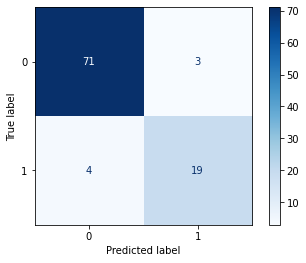

In [65]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [66]:
print("True Positive: %s" % tp)
print("False Positive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

True Positive: 19
False Positive: 3
True Negative: 71
False Negative: 4


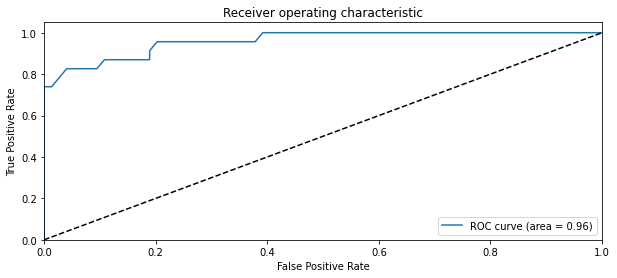

In [67]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

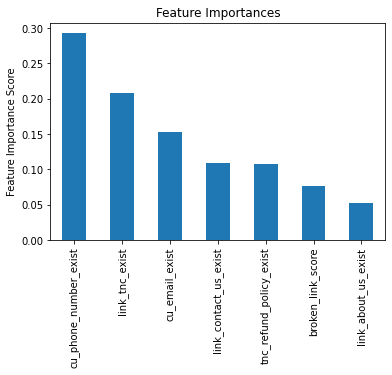

In [70]:
## Calculate feature importance by compute the (normalized) total reduction of the criterion brought by that feature
## Also known as Gini Importance
feat_score = clf.feature_importances_
feat_name = X_train_chosen.columns.values

feat_imp = pd.Series(index=feat_name, data=feat_score).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

## Dump To Pickle

In [50]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [105]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()